# Stock prediction using LSTM 
## FTSE Bursa Malaysia KLCI Index (FBM KLCI)
##### *open in tf env

In [28]:
import keras
import keras.backend as K
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

import pandas as pd
import datetime
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mandates


print("All library loaded.")

All library loaded.


In [4]:
# get historical data from Yahoo Finance for FTSE Bursa Malaysia KLCI (fbmkl)
fbmkl = yf.Ticker("^KLSE")
fbmkl = fbmkl.history(period="max")
# fbmkl.reset_index(inplace=True)
fbmkl

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-12-03 00:00:00+08:00,1018.729980,1027.410034,1018.729980,1023.919983,0,0.0,0.0
1993-12-06 00:00:00+08:00,1027.680054,1041.109985,1027.680054,1041.109985,0,0.0,0.0
1993-12-07 00:00:00+08:00,1046.089966,1063.250000,1046.089966,1063.250000,0,0.0,0.0
1993-12-08 00:00:00+08:00,1064.800049,1071.020020,1060.250000,1060.790039,0,0.0,0.0
1993-12-09 00:00:00+08:00,1059.939941,1067.339966,1058.180054,1067.339966,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-01 00:00:00+08:00,1458.900024,1462.560059,1449.020020,1451.239990,98171000,0.0,0.0
2023-08-02 00:00:00+08:00,1449.449951,1450.280029,1441.849976,1444.560059,91589600,0.0,0.0
2023-08-03 00:00:00+08:00,1441.369995,1442.780029,1433.040039,1441.849976,89240200,0.0,0.0


### Cleaning & visualizing data
#### Date format, remove unwanted column

In [5]:
fbmkl.reset_index(inplace=True) # reset index to allow Date format
fbmkl["Date"] = fbmkl["Date"].dt.strftime("%Y-%m-%d") # reformat date
fbmkl.set_index("Date", inplace=True) # set Date as index again
fbmkl = fbmkl.drop(["Dividends", "Stock Splits"],axis=1) # specify drop column
fbmkl

,Open,High,Low,Close,Volume
Date,,,,,
1993-12-03,1018.729980,1027.410034,1018.729980,1023.919983,0
1993-12-06,1027.680054,1041.109985,1027.680054,1041.109985,0
1993-12-07,1046.089966,1063.250000,1046.089966,1063.250000,0
1993-12-08,1064.800049,1071.020020,1060.250000,1060.790039,0
1993-12-09,1059.939941,1067.339966,1058.180054,1067.339966,0
...,...,...,...,...,...
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200


In [6]:
# using matplotlib to plot date as index (date index is of object type) takes longer time
# make a copy of data where index is reset
fbmkl_rst = fbmkl.copy()
fbmkl_rst.reset_index(inplace=True)
fbmkl_rst.tail()

,Date,Open,High,Low,Close,Volume
7286,2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
7287,2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
7288,2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200
7289,2023-08-04,1442.489990,1447.130005,1442.229980,1445.209961,70523900
7290,2023-08-07,1444.890015,1449.380005,1442.130005,1445.810059,0


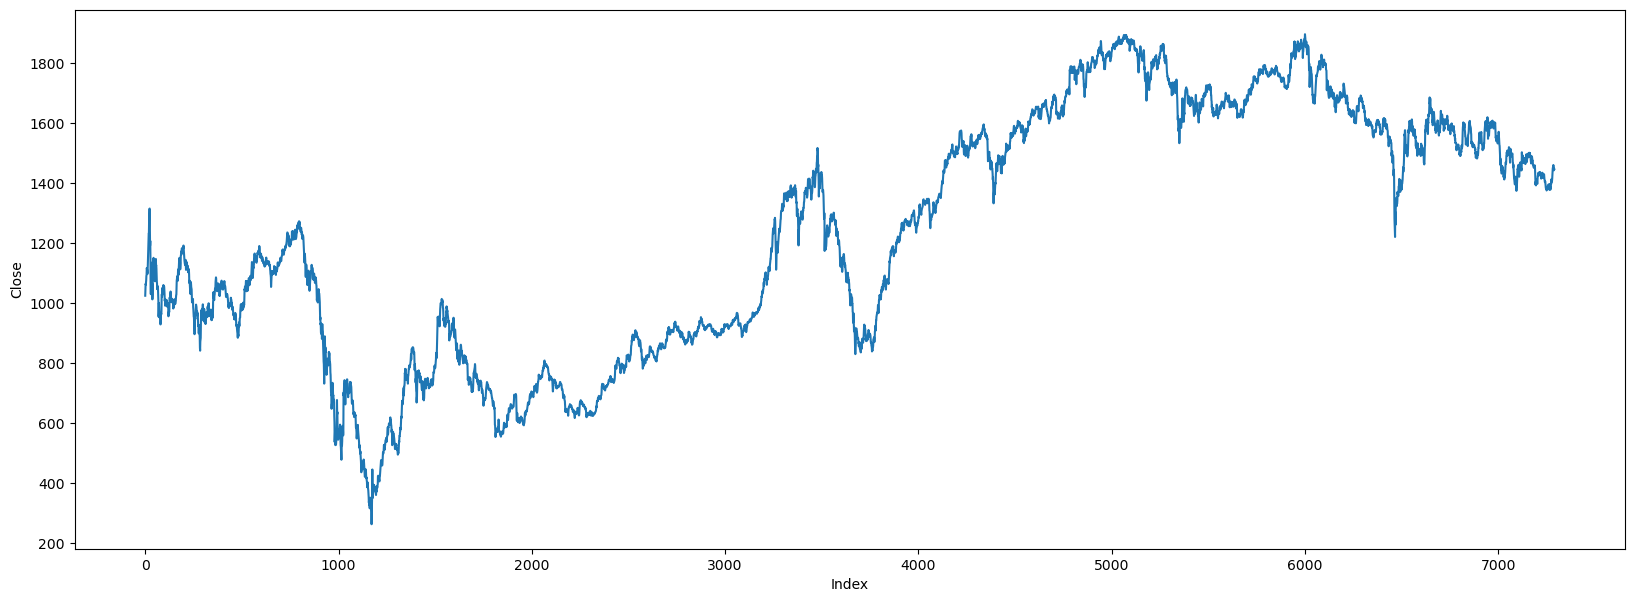

In [7]:
plt.figure(figsize = (20,7))
plt.plot(fbmkl_rst["Close"])
plt.xlabel("Index")
plt.ylabel("Close")
plt.show()

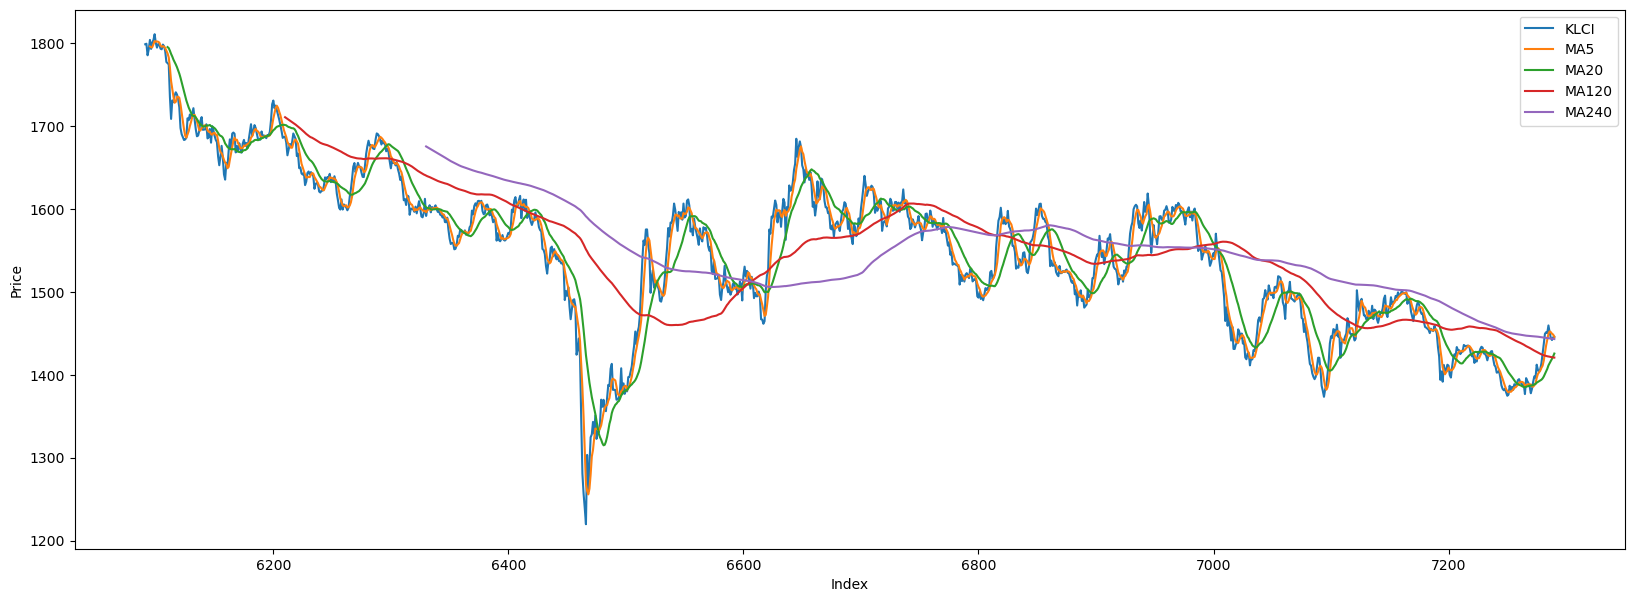

In [8]:
# to illustrate rolling mean = moving average, window 20~1 month, 120~3months, 240~1 year
_close = fbmkl_rst["Close"].iloc[-1200:] # show only the latest 5 years
ma5 = _close.rolling(window=5).mean()
ma20 = _close.rolling(window=20).mean()
ma120 = _close.rolling(window=120).mean()
ma240 = _close.rolling(window=240).mean()

plt.figure(figsize=(20,7))
_close.plot(label="KLCI")
ma5.plot(label="MA5")
ma20.plot(label="MA20")
ma120.plot(label="MA120")
ma240.plot(label="MA240")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

moving averages (MA) of 5 takes the mean of 5 previous days. The plot of MA 5 days follow the KLCI chart the closest compare to MA of 20, 120 or 240.

In [9]:
fbmkl_rst_d = fbmkl_rst.copy() # make copy

In [10]:
fbmkl_rst_d.shape

(7291, 6)

In [11]:
fbmkl_rst_d.info

<bound method DataFrame.info of             Date         Open         High          Low        Close    Volume
0     1993-12-03  1018.729980  1027.410034  1018.729980  1023.919983         0
1     1993-12-06  1027.680054  1041.109985  1027.680054  1041.109985         0
2     1993-12-07  1046.089966  1063.250000  1046.089966  1063.250000         0
3     1993-12-08  1064.800049  1071.020020  1060.250000  1060.790039         0
4     1993-12-09  1059.939941  1067.339966  1058.180054  1067.339966         0
...          ...          ...          ...          ...          ...       ...
7286  2023-08-01  1458.900024  1462.560059  1449.020020  1451.239990  98171000
7287  2023-08-02  1449.449951  1450.280029  1441.849976  1444.560059  91589600
7288  2023-08-03  1441.369995  1442.780029  1433.040039  1441.849976  89240200
7289  2023-08-04  1442.489990  1447.130005  1442.229980  1445.209961  70523900
7290  2023-08-07  1444.890015  1449.380005  1442.130005  1445.810059         0

[7291 rows x 6 colu

### Long Short-Term Model (LSTM) model
##### Long short-term memory (LSTM) is a specialized architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns to future events. 
##### A type of Recurrent Neural Network (RNN).

In [12]:
# split data into a train & test set by 80:20
train_data = fbmkl_rst_d.iloc[:-1500] # take all except the last 1500
test_data = fbmkl_rst_d.iloc[-1500:]  # take the last 1500 

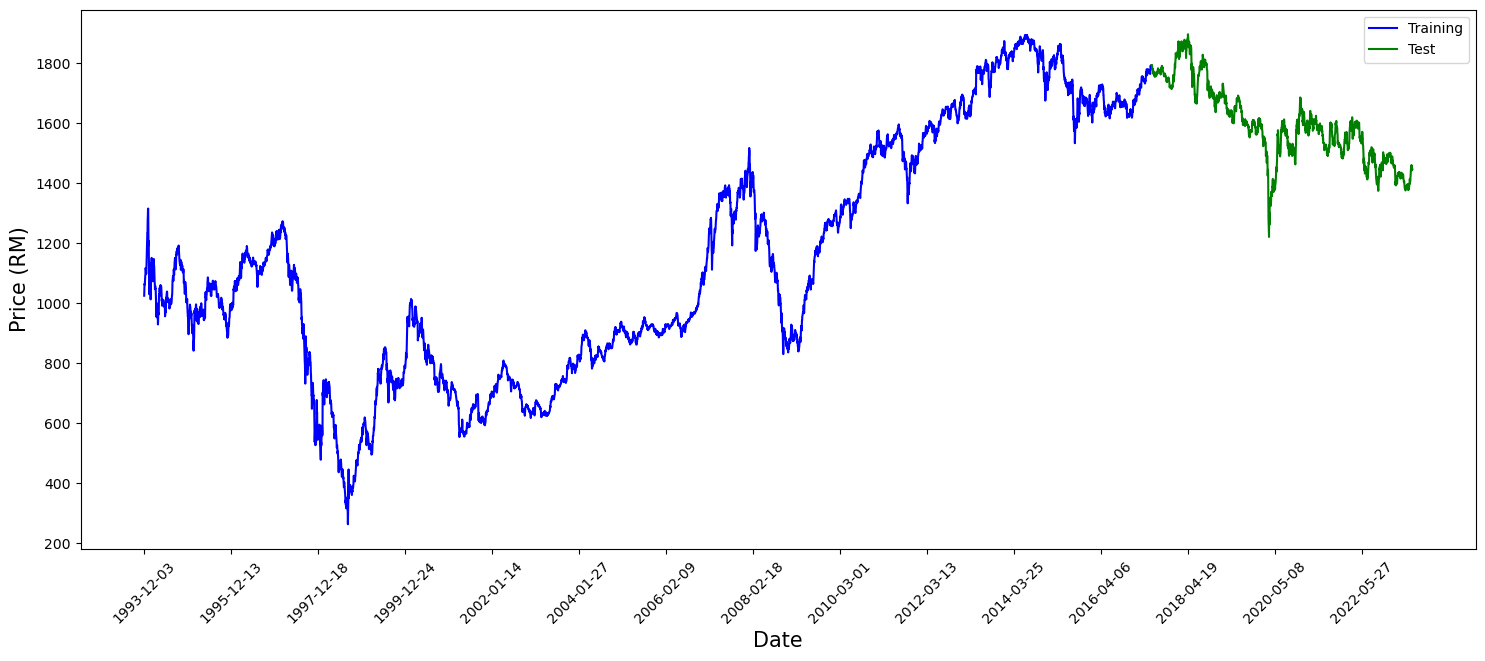

In [13]:
# show plot of train & test data
plt.figure(figsize=(18,7))
plt.plot(train_data["Close"], "blue", label="Training")
plt.plot(test_data["Close"], "green", label="Test")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Price (RM)", fontsize=15)
plt.xticks(np.arange(0, 7290, 500), fbmkl_rst_d["Date"][0:7290:500], rotation=45)
plt.legend()

In [14]:
data_copy = fbmkl_rst_d.copy()

In [16]:
data_copy.shape, data_copy.isnull().values.any()

((7291, 6), False)

In [17]:
data_copy

,Date,Open,High,Low,Close,Volume
0,1993-12-03,1018.729980,1027.410034,1018.729980,1023.919983,0
1,1993-12-06,1027.680054,1041.109985,1027.680054,1041.109985,0
2,1993-12-07,1046.089966,1063.250000,1046.089966,1063.250000,0
3,1993-12-08,1064.800049,1071.020020,1060.250000,1060.790039,0
4,1993-12-09,1059.939941,1067.339966,1058.180054,1067.339966,0
...,...,...,...,...,...,...
7286,2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
7287,2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
7288,2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200
7289,2023-08-04,1442.489990,1447.130005,1442.229980,1445.209961,70523900


In [18]:
data_copy.set_index("Date", inplace=True) # set Date as index
data_copy

,Open,High,Low,Close,Volume
Date,,,,,
1993-12-03,1018.729980,1027.410034,1018.729980,1023.919983,0
1993-12-06,1027.680054,1041.109985,1027.680054,1041.109985,0
1993-12-07,1046.089966,1063.250000,1046.089966,1063.250000,0
1993-12-08,1064.800049,1071.020020,1060.250000,1060.790039,0
1993-12-09,1059.939941,1067.339966,1058.180054,1067.339966,0
...,...,...,...,...,...
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200


In [20]:
# set target variable
target_var = data_copy["Close"] 

# select features
features = ["Open", "High", "Low", "Volume"]

In [22]:
# scaling
scaler = MinMaxScaler()
feature_tx = scaler.fit_transform(data_copy[features])
feature_tx = pd.DataFrame(columns=features, data=feature_tx, index=data_copy.index)
feature_tx.head()

,Open,High,Low,Volume
Date,,,,
1993-12-03,0.460793,0.457337,0.464569,0.0
1993-12-06,0.466297,0.465894,0.470058,0.0
1993-12-07,0.477619,0.479722,0.481350,0.0
1993-12-08,0.489124,0.484576,0.490036,0.0
1993-12-09,0.486136,0.482277,0.488766,0.0


In [23]:
# create training & test set
tscv = TimeSeriesSplit(n_splits=20) # test data 20%, train 80%
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None)


In [24]:
for train_index, test_index in tscv.split(feature_tx):
    X_train, X_test = feature_tx[:len(train_index)], feature_tx[len(train_index):]
    y_train, y_test = target_var[:len(train_index)].values.ravel(), target_var[len(train_index):].values.ravel()
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6944, 4) (347, 4)
(6944,) (347,)


In [25]:
# data processing for LSTM; to match the format (nos. of samples, 1, nos. of features)
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(trainX.shape, trainX.shape)
print(X_train.shape, X_test.shape)

(6944, 4) (6944, 4)
(6944, 1, 4) (347, 1, 4)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


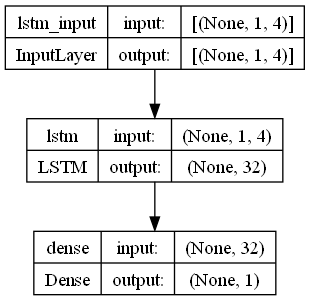

In [31]:
# build model
layers = [LSTM(units=32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False),
        Dense(units=1)]

lstm_model = Sequential(layers=layers)
lstm_model.summary()
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

In [37]:
# compile model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
#train model
history=lstm_model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=.20, shuffle=False)

Epoch 1/50
556/556 [==============================] - 5s 4ms/step - loss: 611.5009 - val_loss: 706.2065
Epoch 2/50
556/556 [==============================] - 2s 4ms/step - loss: 550.8724 - val_loss: 605.9629
Epoch 3/50
556/556 [==============================] - 2s 3ms/step - loss: 471.3982 - val_loss: 520.4778
Epoch 4/50
556/556 [==============================] - 2s 4ms/step - loss: 395.3150 - val_loss: 446.8752
Epoch 5/50
556/556 [==============================] - 2s 3ms/step - loss: 326.5368 - val_loss: 383.8848
Epoch 6/50
556/556 [==============================] - 2s 4ms/step - loss: 267.1035 - val_loss: 330.9200
Epoch 7/50
556/556 [==============================] - 2s 4ms/step - loss: 217.9229 - val_loss: 287.6133
Epoch 8/50
556/556 [==============================] - 2s 4ms/step - loss: 178.9237 - val_loss: 253.4158
Epoch 9/50
556/556 [==============================] - 2s 4ms/step - loss: 149.2287 - val_loss: 227.3034
Epoch 10/50
556/556 [==============================] - 2s 4ms/st

In [39]:
#LSTM Prediction
y_pred= lstm_model.predict(X_test)

11/11 [==============================] - 0s 3ms/step


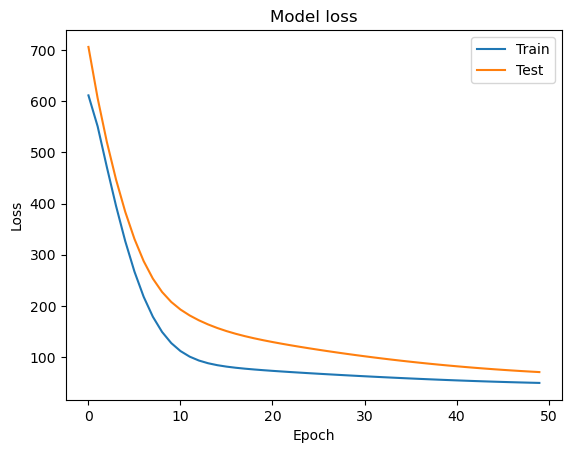

In [40]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

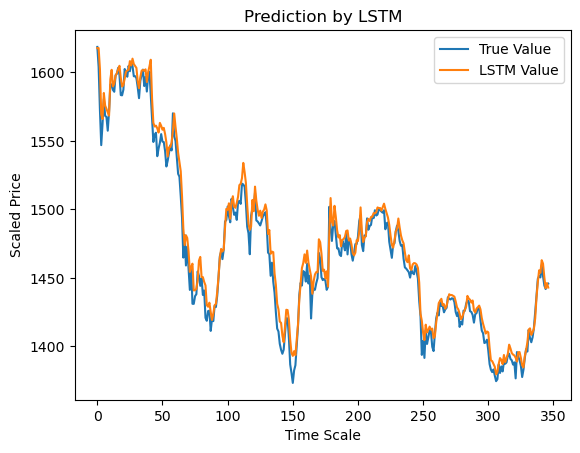

In [41]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()